In [1]:
import os
import cv2
from tensorflow import keras
from tensorflow.keras import layers
import keras.preprocessing.image
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import pathlib

In [2]:

data_dir = pathlib.Path("dataset/train")

# Spliting DATA

In [3]:
img_height=200
img_width=200
batch_size=10
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9900 files belonging to 3 classes.
Using 8910 files for training.


In [4]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9900 files belonging to 3 classes.
Using 990 files for validation.


In [5]:
class_names = train_ds.class_names
print(class_names)

['abw', 'neg', 'pbw']



# Visualize your data

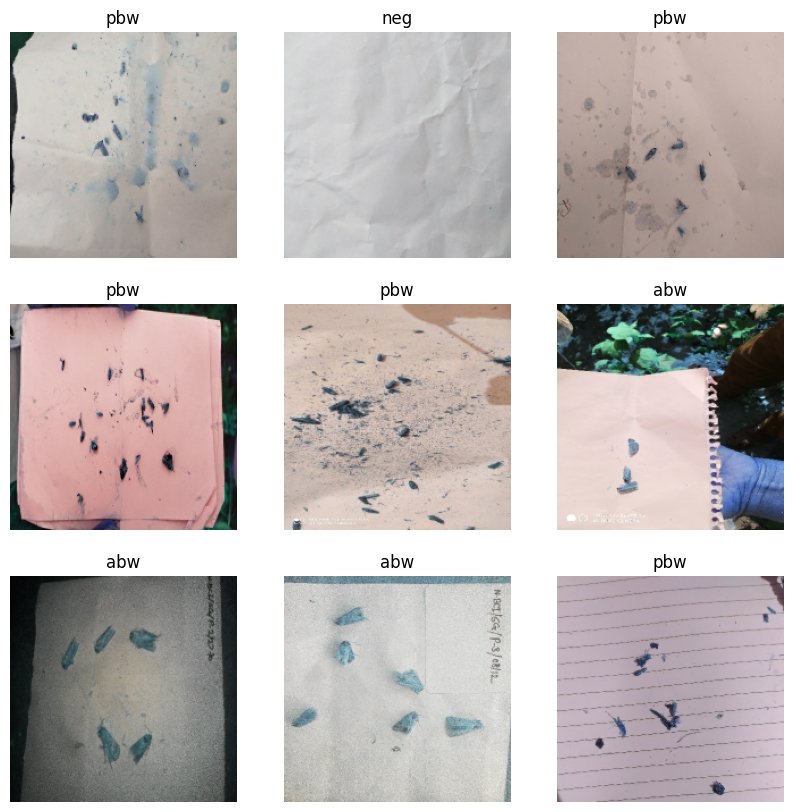

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [7]:
buffer_size=50

train_ds = train_ds.cache().shuffle(buffer_size).prefetch(buffer_size=buffer_size)
val_ds = val_ds.cache().shuffle(buffer_size).prefetch(buffer_size=buffer_size)

In [8]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [9]:
train_normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(train_normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))

0.083333336 0.95588243


In [10]:
val_normalized_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(val_normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))

0.0 0.9960785


In [11]:
num_classes = 3

In [12]:
pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(img_height,img_width,3),
                   pooling='avg',classes=num_classes,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=True

In [13]:


model = Sequential()
  
model.add(pretrained_model)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes,activation='softmax'))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 23,850,371
Trainable params: 23,797,251
Non-trainable params: 53,120
_________________________________________________________________


In [16]:
model.compile(optimizer=Adam(learning_rate=0.01),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [17]:
history =model.fit(train_normalized_ds, validation_data=val_normalized_ds, epochs=10)

Epoch 1/10
891/891 [==============================] - 748s 824ms/step - loss: 1.0573 - accuracy: 0.5018 - val_loss: 1.0167 - val_accuracy: 0.4869
Epoch 2/10
891/891 [==============================] - 731s 821ms/step - loss: 0.8765 - accuracy: 0.5710 - val_loss: 0.7876 - val_accuracy: 0.6525
Epoch 3/10
891/891 [==============================] - 731s 821ms/step - loss: 0.7823 - accuracy: 0.6708 - val_loss: 1.3263 - val_accuracy: 0.5091
Epoch 4/10
891/891 [==============================] - 732s 821ms/step - loss: 0.8095 - accuracy: 0.6466 - val_loss: 1.0974 - val_accuracy: 0.5020
Epoch 5/10
891/891 [==============================] - 732s 822ms/step - loss: 0.7005 - accuracy: 0.7153 - val_loss: 0.8326 - val_accuracy: 0.6303
Epoch 6/10
891/891 [==============================] - 734s 824ms/step - loss: 0.6574 - accuracy: 0.7285 - val_loss: 0.5601 - val_accuracy: 0.7990
Epoch 7/10
891/891 [==============================] - 734s 824ms/step - loss: 0.7334 - accuracy: 0.6946 - val_loss: 0.6694 -

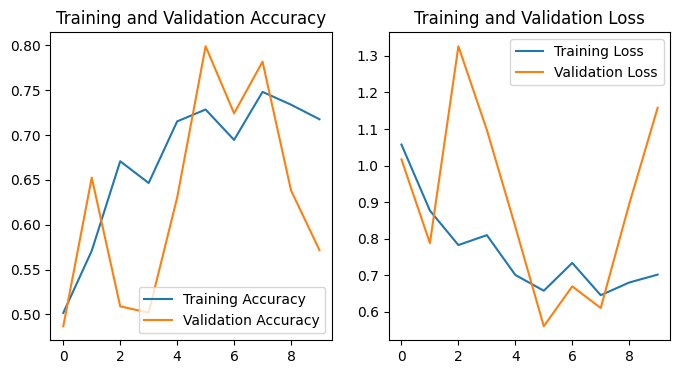

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

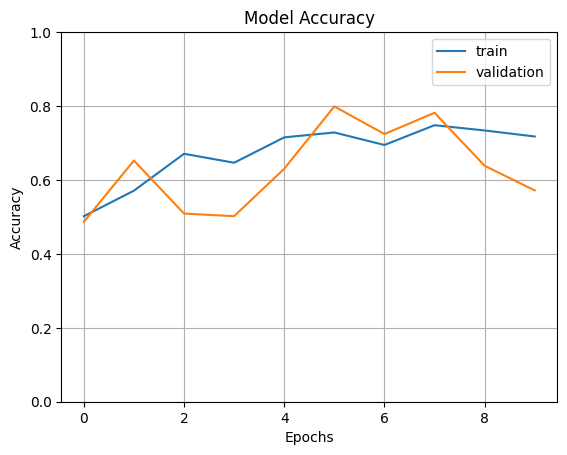

In [19]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

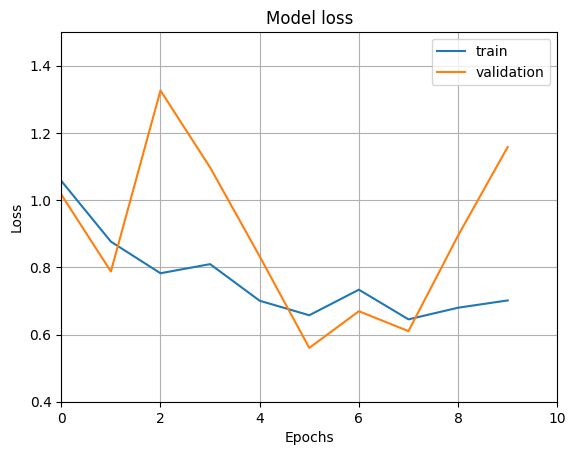

In [22]:
fig1 = plt.gcf()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.axis(ymin=0.4,ymax=1.5)
plt.axis(xmin=0,xmax=10)
plt.grid()
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

# test img load

In [29]:
DIRECTORY= r'C:\Users\manju\Desktop\ml-project\images'

1/1 [==============================] - 0s 31ms/step
The predicted class is neg


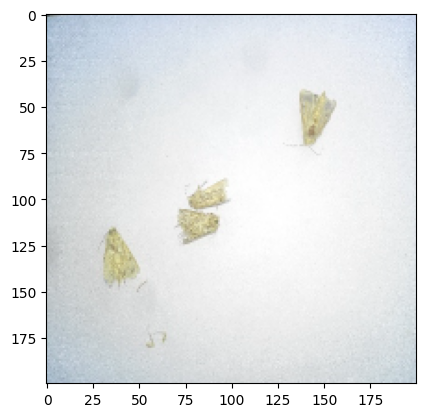

The image ID= id_00332970f80fa9a47a39516d_neg
1/1 [==============================] - 0s 30ms/step
The predicted class is neg


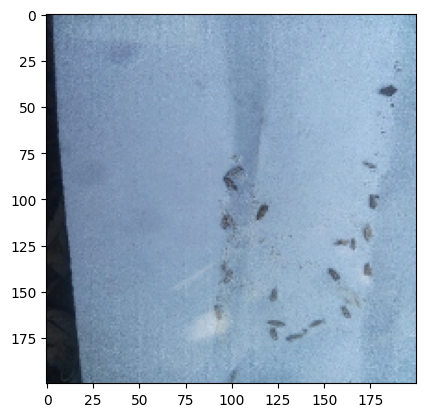

The image ID= id_0035981bc3ae42eb5b57a317_neg
1/1 [==============================] - 0s 32ms/step
The predicted class is neg


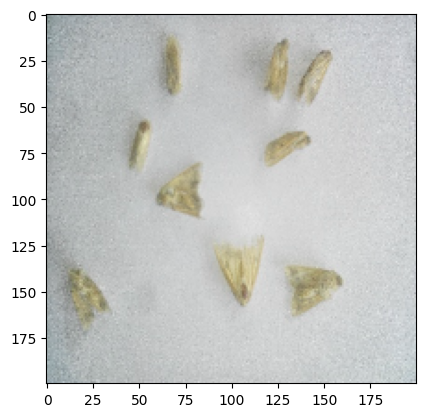

The image ID= id_005102f664b820f778291dee_neg
1/1 [==============================] - 0s 30ms/step
The predicted class is neg


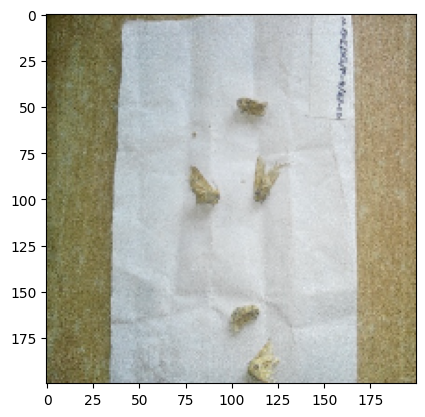

The image ID= id_0066456f5fb2cd858c69ab39_neg
1/1 [==============================] - 0s 30ms/step
The predicted class is neg


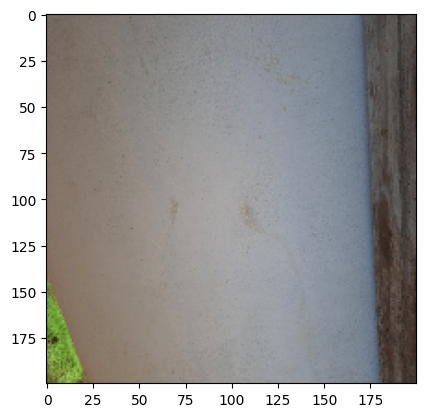

The image ID= id_007159c1fa015ba6f394deeb_neg
1/1 [==============================] - 0s 30ms/step
The predicted class is neg


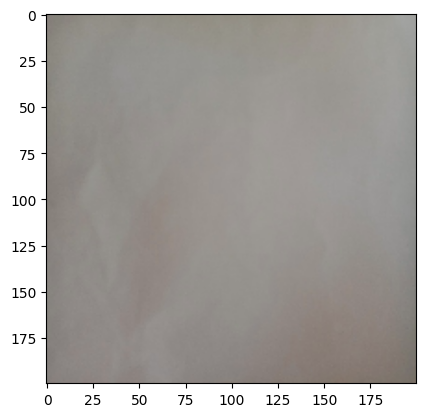

The image ID= id_0087ad7987b3f82bc5b5c7d0_neg
1/1 [==============================] - 0s 31ms/step
The predicted class is neg


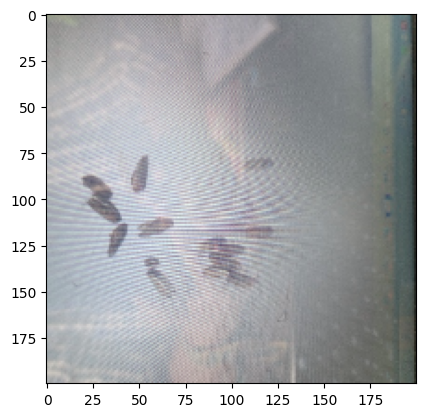

The image ID= id_00887bebda26184c36e18e00_neg
1/1 [==============================] - 0s 30ms/step
The predicted class is neg


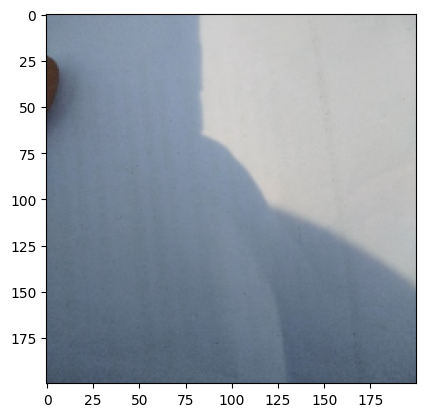

The image ID= id_00ba116c0f45a71a7e0e652c_neg
1/1 [==============================] - 0s 30ms/step
The predicted class is pbw


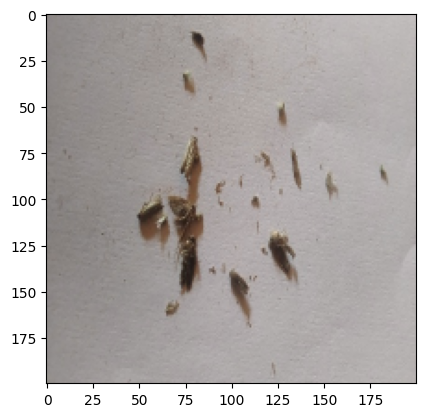

The image ID= id_00c11f7689e2351305cb12e3_pbw
1/1 [==============================] - 0s 33ms/step
The predicted class is neg


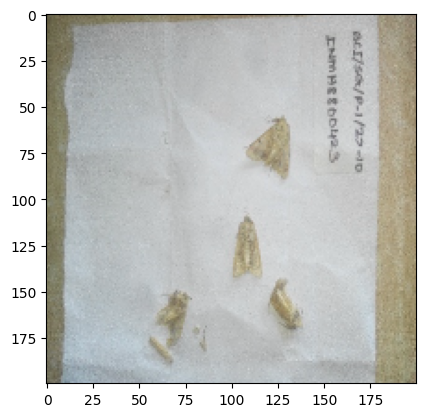

The image ID= id_00c1c4a5f0e0354f8e2aa416_neg
1/1 [==============================] - 0s 31ms/step
The predicted class is neg


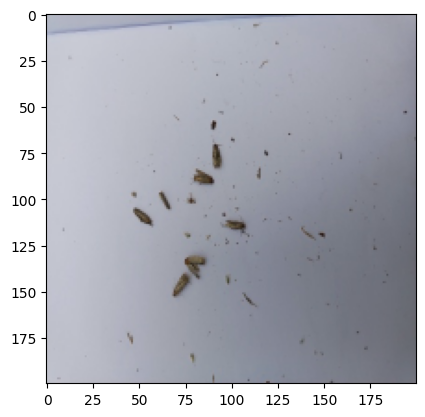

The image ID= id_00dcb00a08a4aeafff1359da_neg
1/1 [==============================] - 0s 32ms/step
The predicted class is neg


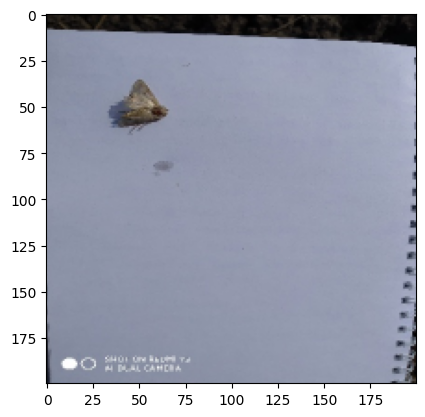

The image ID= id_00e16adc89f71646eafaca69_neg
1/1 [==============================] - 0s 32ms/step
The predicted class is neg


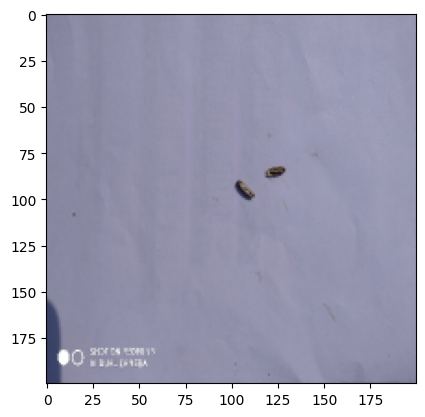

The image ID= id_00eb9a777926488215ce62ed_neg
1/1 [==============================] - 0s 32ms/step
The predicted class is neg


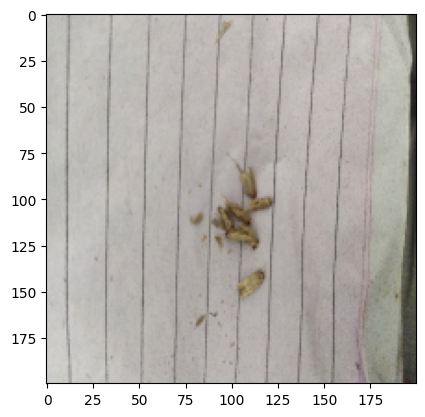

The image ID= id_00f9ce0575a49398f290186b_neg
1/1 [==============================] - 0s 30ms/step
The predicted class is neg


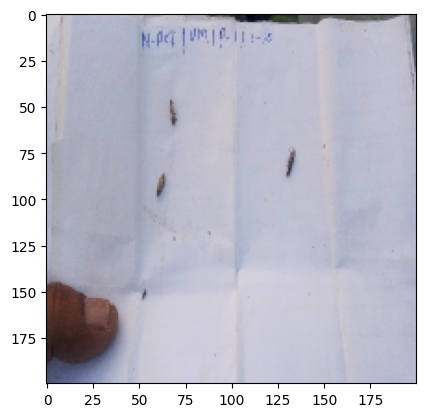

The image ID= id_011bb96d55f9a0823a2caae6_neg
1/1 [==============================] - 0s 29ms/step
The predicted class is neg


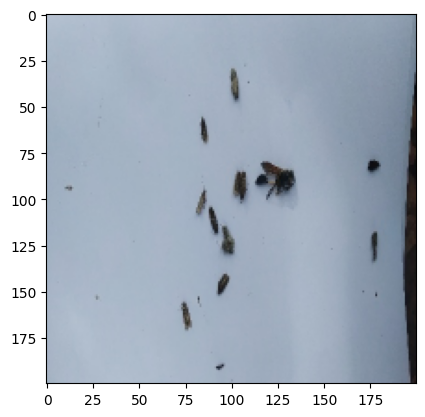

The image ID= id_012a8855adcc9ca2a522d771_neg
1/1 [==============================] - 0s 28ms/step
The predicted class is neg


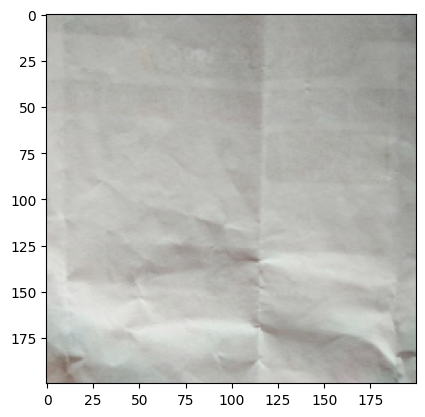

The image ID= id_012f50e13a438474cc63b7b7_neg
1/1 [==============================] - 0s 30ms/step
The predicted class is neg


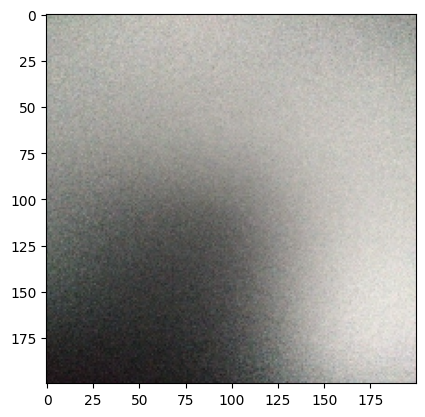

The image ID= id_016185ddae947c538eac2c33_neg
1/1 [==============================] - 0s 30ms/step
The predicted class is neg


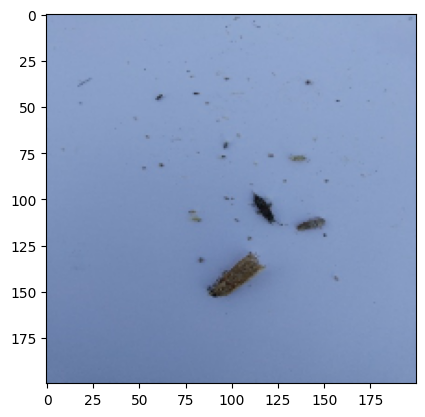

The image ID= id_016965ccadb213b2f74fc1e6_neg
1/1 [==============================] - 0s 16ms/step
The predicted class is neg


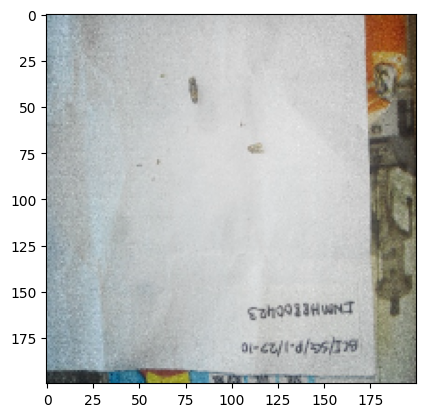

The image ID= id_01790f69486d24f4d22f8bf9_neg
1/1 [==============================] - 0s 31ms/step
The predicted class is neg


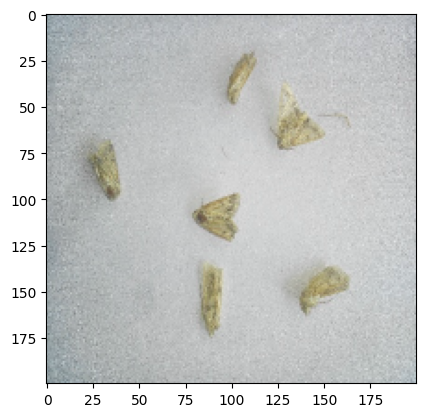

The image ID= id_017f0b03f1c86cf4df9f9811_neg
1/1 [==============================] - 0s 29ms/step
The predicted class is neg


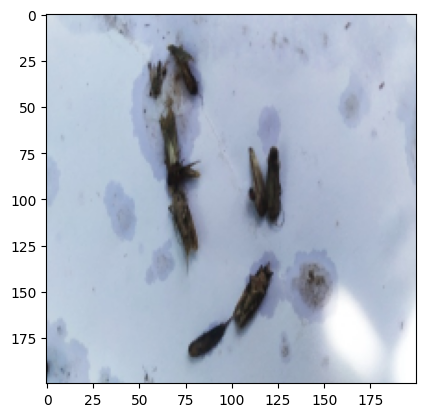

The image ID= id_0192241cfd3684ed17185acf_neg
1/1 [==============================] - 0s 34ms/step
The predicted class is neg


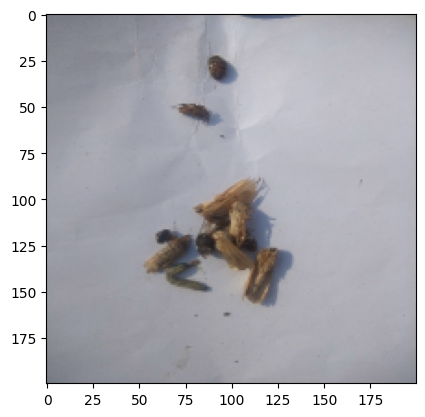

The image ID= id_01a90d01ea45b5f4a25a8579_neg
1/1 [==============================] - 0s 34ms/step
The predicted class is neg


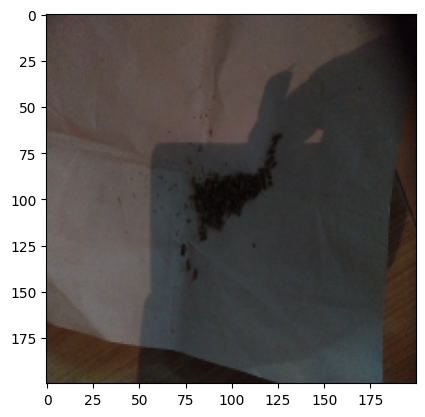

The image ID= id_01c70107aed2aa2cded0f3c3_neg
1/1 [==============================] - 0s 31ms/step
The predicted class is neg


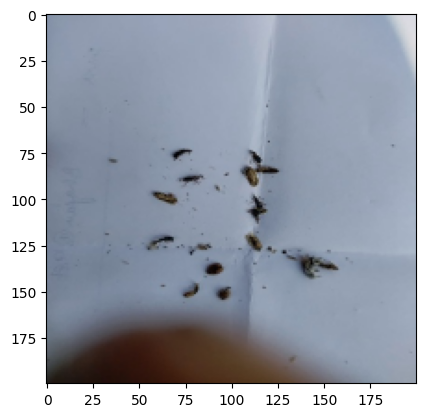

The image ID= id_01d1cc351e167df77cf8ac8b_neg


In [28]:
count=0
for img in os.listdir(DIRECTORY):
    img_path=os.path.join(DIRECTORY,img)
    img_array=cv2.imread(img_path)
    img_array=cv2.resize(img_array,(200,200))
    img_array_=img_array/255
    img_array_=np.expand_dims(img_array_,axis=0)
    pred=model.predict(np.array(img_array_))
    output_class=class_names[np.argmax(pred)]
  
    values = (img[:-4] + "_" + output_class)

    print("The predicted class is", output_class)
    plt.imshow(img_array)
    plt.show()
    print("The image ID=",values)
    count+=1
    if(count==25):
        break
    if(output_class=='abw'):
         break



In [31]:
d

['id_0002ea6f15c7fa6f4c221783_pbw',
 'id_0005ef295aafe6acc63587db_pbw',
 'id_00084298dd030a500033ff78_neg',
 'id_00093f2c76f6488737325859_pbw',
 'id_000b2e6c437c643f25d4a6c3_neg',
 'id_000c2040da4b05816cefbb96_neg',
 'id_001149c0de05ea4941d966e0_neg',
 'id_001e574d805941d7f2cb0302_pbw',
 'id_001f4346191855c521871616_neg',
 'id_002087d55e497d26352496a4_pbw',
 'id_002b8a0e15968eaf2e61f4c7_pbw',
 'id_00332970f80fa9a47a39516d_neg',
 'id_0035981bc3ae42eb5b57a317_pbw',
 'id_003ad8831eae2f0117f5aaf2_pbw',
 'id_00450e8b229932359e7c32a3_pbw',
 'id_004cb31e5bfaba2dab9042e5_pbw',
 'id_005102f664b820f778291dee_neg',
 'id_0051657d3b6b4d7858088283_neg',
 'id_006296f82479c03459102436_neg',
 'id_0066456f5fb2cd858c69ab39_neg',
 'id_00695feae97d7bf88bb498a2_pbw',
 'id_006e9f771965fd78278baa19_neg',
 'id_007159c1fa015ba6f394deeb_neg',
 'id_00750938fb12fad4fd8fad24_neg',
 'id_00773a42b1415d887107663a_pbw',
 'id_007faaec98bbae829fb2b29d_pbw',
 'id_0087ad7987b3f82bc5b5c7d0_neg',
 'id_00887bebda26184c36e18e0

In [179]:
count

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [32]:
dftemp = pd.DataFrame({'image_id_worm':d,'number_of_worms':count})

In [33]:
dftemp

image_id_worm  number_of_worms
0      id_0002ea6f15c7fa6f4c221783_pbw                0
1      id_0005ef295aafe6acc63587db_pbw                0
2      id_00084298dd030a500033ff78_neg                0
3      id_00093f2c76f6488737325859_pbw                0
4      id_000b2e6c437c643f25d4a6c3_neg                0
...                                ...              ...
12535  id_ffe98feb1e592e887b81c3f0_pbw                0
12536  id_ffef90ecf47baa38434f84fb_neg                0
12537  id_fff06bb2e59bfce437ac9fc0_neg                0
12538  id_fff8c253115aacded09ad7ed_pbw                0
12539  id_fffdca893564aa86ff5be4cc_neg                0

[12540 rows x 2 columns]

In [34]:
dftemp.to_csv('Submission5.csv',index=False)

In [123]:
cols = ['type']
df1 = pd.DataFrame( columns=cols)
df1

Empty DataFrame
Columns: [type]
Index: []

In [165]:
dftemp

image_id_worm
0     id_0035981bc3ae42eb5b57a317_pbw
1     id_0066456f5fb2cd858c69ab39_pbw
2     id_00887bebda26184c36e18e00_pbw
3     id_00c11f7689e2351305cb12e3_pbw
4     id_00dcb00a08a4aeafff1359da_pbw
...                               ...
1316  id_ff32de4748412b3ff320a343_pbw
1317  id_ff6b60935a327d1c2779bc5e_abw
1318  id_ffad8f3773a4222f8fe5ba1a_pbw
1319  id_ffb65e6de900c49d8f2ef95a_pbw
1320  id_fff8c253115aacded09ad7ed_pbw

[1321 rows x 1 columns]

In [91]:
result['type']

Series([], Name: type, dtype: object)

In [92]:
type(result)

pandas.core.frame.DataFrame

In [70]:
result.head

<bound method NDFrame.head of Empty DataFrame
Columns: [type]
Index: []>

In [49]:
output_class

'pbw'

In [50]:
type(output_class)

str

In [74]:
print(df)

neg


In [ ]:
import csv

# open the file in the write mode
f = open('path/to/csv_file', 'w')

# create the csv writer
writer = csv.writer(f)

# write a row to the csv file
writer.writerow(row)

# close the file
f.close()